#### Bibliotecas e configuracoes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

# Pacote com todas as funcoes devenvolvidas para esse projeto
from functions_proj_scraping import *

# Configs
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.precision', 2)
warnings.filterwarnings('ignore')

#### Pegar todos os anuncios de todas as paginas do site (macro) com paralelismo

In [ ]:
url = 'https://www.lagoimobiliaria.com.br/pesquisa-de-imoveis/?locacao_venda=V&id_cidade%5B%5D=90&id_tipo_imovel%5B%5D=5&id_tipo_imovel%5B%5D=20&id_tipo_imovel%5B%5D=19&finalidade=residencial&dormitorio=0&garagem=0&vmi=&vma='
#url = 'https://www.lagoimobiliaria.com.br/pesquisa-de-imoveis/?locacao_venda=V&id_cidade%5B%5D=90&id_tipo_imovel%5B%5D=4&finalidade=0&dormitorio=0&garagem=0&vmi=&vma='
paginas = total_paginas_site(url)

base_geral = []

# Funcao para executar o scrapping
def processar_pagina(pag):
    soup = gerando_soup_principal(url, pag)
    pagina = soup.find('div', {'class':'properties_item_two row'}).findAll('div', class_='col-lg-3 col-md-4 col-sm-6 col-xs-12')
    
    resultados_pagina = []
    
    for item in range(0, len(pagina)):
        resultado = dados_pag_principal(pagina[item], item)
        resultados_pagina.append(resultado)
    
    return resultados_pagina

# Paralelismo
with concurrent.futures.ThreadPoolExecutor() as executor:
    resultados_paginas = list(executor.map(processar_pagina, range(paginas)))

# "Aplanhando" a lista de listas para obter uma única lista de resultados
base_geral = [resultado for resultados_pagina in resultados_paginas for resultado in resultados_pagina]

#### Carregando dados macro para dataframe e tratando dados

In [ ]:
# Criando dataframe e Trocando Nan -> 0 e removendo duplicidades
df = pd.DataFrame(base_geral)
df.fillna(0, inplace=True)
df.drop_duplicates(subset=['link'], keep='first', inplace=True, ignore_index=True)

# Criando coluna com nro de indice para merge posterior
df['indice'] = df.index

# Corrigindo encoding no link para evitar erros
df['link'] = df.apply(lambda row: safeStr(row['link']), axis=1)

# Reindexando
df.reset_index(inplace=True, drop=True)

#### Pegando dados complementares de todos os anuncios com paralelismo

In [ ]:
# Funcao para processar o scrapping de cada anuncio especificamente
def processar_anuncio(link, index):
    try:
        pagina = gerando_soup_anuncio(link)
        resultado = dados_pag_anuncio(pagina, index)
        if resultado != 'erro':
            return resultado
    except:
        pass
    return None

# Criando df com links para loop no paralelismo
links = pd.DataFrame(df['link'])

# Criando lista para gravar resultados
base_geral = []

# Usando paralelismo com limite de operacoes simultaneas
with concurrent.futures.ThreadPoolExecutor(max_workers=50) as executor:
    futures = {executor.submit(processar_anuncio, row['link'], index): index for index, row in links.iterrows()}

    # Coletando  e gravando os resultados na lista
    for future in concurrent.futures.as_completed(futures):
        resultado = future.result()
        if resultado:
            base_geral.append(resultado)

#### Carregando dados anuncios para dataframe, tratando dados e combinando bases

In [ ]:
# Criando dataframe e trocando Nan -> 0
df2 = pd.DataFrame(base_geral) 
df2.fillna(0, inplace=True)

# Mesclando df + df2
base_final = df.merge(df2, how='inner', on='indice')
del df, df2

#### Tratando base final

In [ ]:
# Criando coluna de preco
base_final['preco'] = np.where(base_final['valor']>=base_final['valor_venda'],
                               base_final['valor'],
                               base_final['valor_venda'])

base_final['preco'] = np.where(base_final['preco']==base_final['valor_aluguel'],
                               0,
                               base_final['preco'])

# Criando faixa de valores
faixas = ['até 250k','250k a 500k','501k a 750k','751k a 1M','acima 1M']
base_final['faixas_precos'] = pd.cut(base_final['preco'], bins=[0,250000,500000,750000,1000000,1500000], labels=faixas)

# Criando colunas de metragens
base_final['area_total_ou_terreno'] = np.where(base_final['area_total']==0,
                                               base_final['area_terreno'],
                                               base_final['area_total'])

base_final['area_util_ou_construida'] = np.where(base_final['area_util']==0,
                                                 base_final['area_construida'],
                                                 base_final['area_util'])

# Excluindo valores zerados
base_final = base_final[base_final['preco'] > 0]
base_final = base_final[base_final['classificacao'] != '0']
base_final.drop(columns=['indice','valor_venda','valor','area_util','area_total',
                         'area_terreno','area_construida'], inplace=True)

# Convertendo tipagens numericas
base_final = tipagem(base_final)

# Convertendo objetos para categorias
colunas = ['bairro', 'cidade','classificacao','pagina']
base_final[colunas] = base_final[colunas].astype('category')

# Adicionando coluna para simplificar contagens
base_final['registros'] = 1

# Reindexando
base_final.reset_index(inplace=True, drop=True)

# Reorganizando
base_final = base_final[['bairro','cidade','descricao','link','link_foto_capa','classificacao','pagina',
                         'preco','quartos','suites','banheiros','vagas','itens_do_imovel', 'itens_do_condominio',
                         'area_total_ou_terreno', 'area_util_ou_construida','valor_condominio', 'valor_iptu','valor_aluguel']]

#### Removendo outliers

In [ ]:
# Remocao de outliers
base_final = remove_outliers(base_final)

In [ ]:
base_final.to_csv('base_final_anuncios.csv',sep=',', encoding='utf-8', index=False)

#### Plotando histogramas, boxplot e estatisticas descritivas das variaveis

In [12]:
base_final = pd.read_csv('base_final_anuncios.csv', sep=',', encoding='utf-8')

base_final['pagina'] = base_final['pagina'].astype('category')


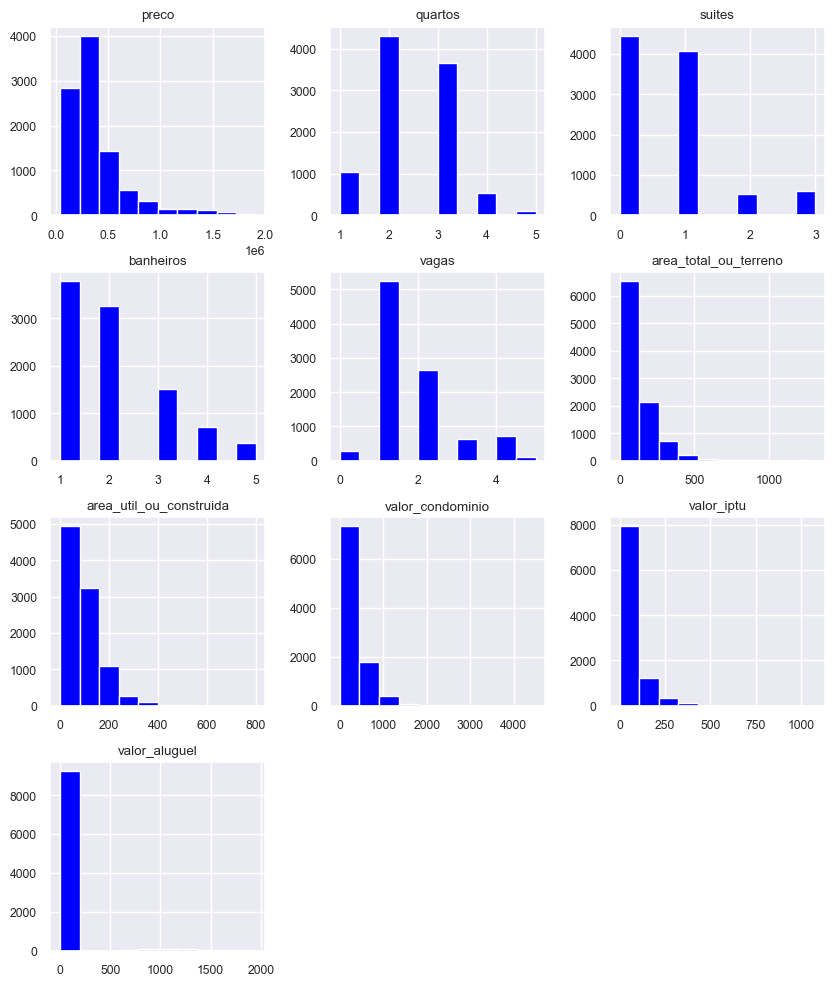

In [13]:
# PLOT DAS VARIAVEIS
sns.set(
    style='darkgrid', # ESTILO
    font_scale=0.8, # FONTE
    rc={'figure.figsize':(10,12)} # TAMANHO
)

graficos = base_final.hist(color='blue')

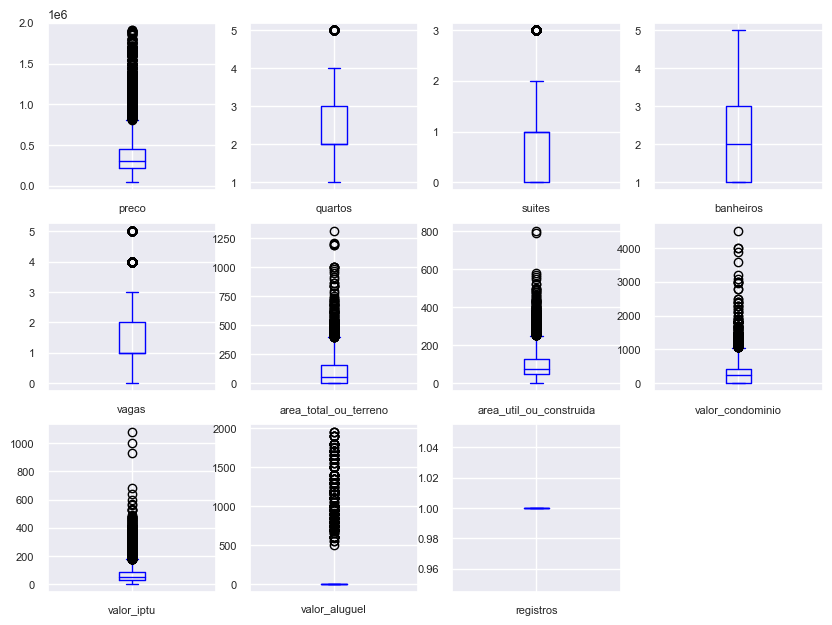

In [61]:
# BOXPLOT
boxplots = base_final.plot(kind='box', subplots=True, layout=(4,4), 
                           sharex=False, sharey=False, color='blue', 
                           figsize=(10,10), fontsize=8)

In [60]:
base_final.head(2)

,bairro,cidade,descricao,link,link_foto_capa,classificacao,pagina,preco,quartos,suites,banheiros,vagas,itens_do_imovel,itens_do_condominio,area_total_ou_terreno,area_util_ou_construida,valor_condominio,valor_iptu,valor_aluguel,registros
0,Planalto Verde,Ribeirão Preto - SP,"casa terrea em otima localizacao, 2 dormitorio...",https://www.lagoimobiliaria.com.br/comprar/Rib...,https://www.lagoimobiliaria.com.br/foto_thumb/...,Casas - Padrão,0,280000.00,2,1.00,2,2.00,"['Ar condicionado', 'Box', 'Churrasqueira', 'V...",[],126.00,109.00,0.00,44.20,0.00,1
1,Jardim Irajá,Ribeirão Preto - SP,excelente apartamento com 3 dormitorios sendo ...,https://www.lagoimobiliaria.com.br/comprar/Rib...,https://www.lagoimobiliaria.com.br/foto_thumb/...,Apartamento - Padrão,1,349900.00,3,1.00,2,1.00,"['Cerca Elétrica', 'Elevador Social: 1', 'Gás ...",[],0.00,82.44,350.00,75.79,0.00,1


In [52]:
def calc_frequency_table(base, col_categ, col_cont):
    total = base[col_cont].count()
    frequency = (base.groupby(by=col_categ, as_index=False)[col_cont].count().rename(columns={col_cont:'freq_abs'}))
    frequency['freq_acum'] = frequency['freq_abs'].cumsum()
    frequency['freq_relat'] = (frequency['freq_abs']/total)*100
    frequency['freq_relat_acum'] = frequency['freq_relat'].cumsum()
    
    return frequency

In [91]:
frequency = calc_frequency_table(base_final,['classificacao','faixas_precos'],'registros')
frequency

,classificacao,faixas_precos,freq_abs,freq_acum,freq_relat,freq_relat_acum
0,Apartamento - Padrão,até 250k,3048,3048,31.60,31.60
1,Apartamento - Padrão,250k a 500k,2254,5302,23.37,54.97
2,Apartamento - Padrão,501k a 750k,547,5849,5.67,60.64
3,Apartamento - Padrão,751k a 1M,190,6039,1.97,62.61
4,Apartamento - Padrão,acima 1M,150,6189,1.56,64.17
5,Casas - Condomínio,até 250k,19,6208,0.20,64.36
6,Casas - Condomínio,250k a 500k,59,6267,0.61,64.98
7,Casas - Condomínio,501k a 750k,65,6332,0.67,65.65
8,Casas - Condomínio,751k a 1M,58,6390,0.60,66.25
9,Casas - Condomínio,acima 1M,166,6556,1.72,67.97


In [90]:
cruzamento = base_final.groupby(['classificacao','faixas_precos'],as_index=False).agg({'preco':'mean','registros':'sum'})

cruzamento['freq'] = (cruzamento['registros'] / base_final['registros'].sum()) * 100

cruzamento

,classificacao,faixas_precos,preco,registros,freq
0,Apartamento - Padrão,até 250k,188894.94,3048,31.60
1,Apartamento - Padrão,250k a 500k,345749.77,2254,23.37
2,Apartamento - Padrão,501k a 750k,615294.19,547,5.67
3,Apartamento - Padrão,751k a 1M,874220.47,190,1.97
4,Apartamento - Padrão,acima 1M,1249357.49,150,1.56
5,Casas - Condomínio,até 250k,217994.74,19,0.20
6,Casas - Condomínio,250k a 500k,378949.15,59,0.61
7,Casas - Condomínio,501k a 750k,619252.31,65,0.67
8,Casas - Condomínio,751k a 1M,893482.76,58,0.60
9,Casas - Condomínio,acima 1M,1253680.72,166,1.72


In [89]:
total = base_final['registros'].sum()
total

9645

In [73]:
base_final.head()

,bairro,cidade,descricao,link,link_foto_capa,classificacao,pagina,preco,quartos,suites,...,vagas,itens_do_imovel,itens_do_condominio,area_total_ou_terreno,area_util_ou_construida,valor_condominio,valor_iptu,valor_aluguel,registros,faixas_precos
0,Planalto Verde,Ribeirão Preto - SP,"casa terrea em otima localizacao, 2 dormitorio...",https://www.lagoimobiliaria.com.br/comprar/Rib...,https://www.lagoimobiliaria.com.br/foto_thumb/...,Casas - Padrão,0,280000.00,2,1.00,...,2.00,"['Ar condicionado', 'Box', 'Churrasqueira', 'V...",[],126.00,109.00,0.00,44.20,0.00,1,250k a 500k
1,Jardim Irajá,Ribeirão Preto - SP,excelente apartamento com 3 dormitorios sendo ...,https://www.lagoimobiliaria.com.br/comprar/Rib...,https://www.lagoimobiliaria.com.br/foto_thumb/...,Apartamento - Padrão,1,349900.00,3,1.00,...,1.00,"['Cerca Elétrica', 'Elevador Social: 1', 'Gás ...",[],0.00,82.44,350.00,75.79,0.00,1,250k a 500k
2,Reserva Sul Condomínio,Ribeirão Preto - SP,apartamento com 2 dormitorios completos em arm...,https://www.lagoimobiliaria.com.br/comprar/Rib...,https://www.lagoimobiliaria.com.br/foto_thumb/...,Apartamento - Padrão,2,250000.00,2,0.00,...,1.00,"['Ar condicionado', 'Armário Embutido', 'Box',...","['Apartamento por Andar: 8', 'Quantidade de An...",48.24,48.24,362.00,59.75,0.00,1,até 250k
3,Campos Elíseos,Ribeirão Preto - SP,excelente apartamento terreo com 03 dormitorio...,https://www.lagoimobiliaria.com.br/comprar/Rib...,https://www.lagoimobiliaria.com.br/foto_thumb/...,Apartamento - Padrão,3,270000.00,3,1.00,...,1.00,"['Box', 'Iluminação', 'Quintal', 'Térreo']",['Portão Eletrônico'],64.15,64.15,150.00,56.00,0.00,1,250k a 500k
4,Quinta Da Boa Vista,Ribeirão Preto - SP,"casa em condominio no vivendas da mata, em ter...",https://www.lagoimobiliaria.com.br/comprar/Rib...,https://www.lagoimobiliaria.com.br/foto_thumb/...,Casas - Condomínio,4,1300000.00,3,3.00,...,4.00,"['Campo de Futebol', 'Churrasqueira', 'Espaço ...",[],300.00,166.00,580.00,0.00,0.00,1,acima 1M
